<img align="right" src="https://druggablegenome.net/IDG_Images_Index/IDGLOGO.png" width="400">
# TIN-X API Introduction
### TIN-X REST API examples.
  * http://api.newdrugtargets.org/
  * http://api.newdrugtargets.org/docs/
  * http://newdrugtargets.org/
 
<a href="https://academic.oup.com/bioinformatics/article/3111842/TIN-X-Target-Importance-and-Novelty-Explorer" target="_blank">TIN-X: Target Importance and Novelty Explorer</a>, DC Cannon, JJ Yang, SL Mathias, O Ursu, S Mani, A Waller, SC Schürer, LJ Jensen, LA Sklar, CG Bologa, TI Oprea, Bioinformatics, 2017, btx200, doi: 10.1093/bioinformatics/btx200.

### Imports

In [1]:
import sys,os
import scipy,numpy
import pandas
import matplotlib,matplotlib.pyplot
import altair
print('Python: %s; Pandas: %s; Scipy: %s ; Numpy: %s; Matplotlib: %s; Altair: %s'%(sys.version.split()[0],pandas.__version__,scipy.__version__,numpy.__version__,matplotlib.__version__, altair.__version__))

Python: 3.6.6; Pandas: 0.22.0; Scipy: 0.19.1 ; Numpy: 1.14.6; Matplotlib: 2.1.2; Altair: 2.2.2


### Install coreapi

In [2]:
!pip install coreapi
import coreapi
print('Coreapi: %s'%(coreapi.__version__))

  Running setup.py bdist_wheel for itypes ... - done
  Stored in directory: /root/.cache/pip/wheels/7b/52/af/4e27324812e7ab7bbbc30f748d317f3739477562325cb4c723
  Running setup.py bdist_wheel for coreschema ... - done
  Stored in directory: /root/.cache/pip/wheels/10/7b/ba/04fcd6b33e6123ca11a5f5ab56decb1a2d87ced028377a1377
Successfully built itypes coreschema
Coreapi: 2.3.3


### Instantiate Coreapi client. Fetch TIN-X API schema.

In [0]:
client = coreapi.Client()
schema = client.get("http://api.newdrugtargets.org/docs/")

### Search for "Gout", rank by name length.

In [4]:
action = ["diseases", "list"]
params = { "search": "Gout", "limit": 10, "offset": 0 }
response = client.action(schema, action, params=params)
diseases = pandas.DataFrame(response['results'])
diseases[['id', 'doid', 'name', 'summary']]
diseases.reindex(diseases.name.str.len().sort_values().index)

,id,doid,name,summary,novelty,targets,children
0,62,DOID:13189,gout,An arthritis that has_material_basis_in uric a...,0.0009847300000000,http://api.newdrugtargets.org/diseases/62/targ...,http://api.newdrugtargets.org/diseases/62/chil...


### Fetch targets for top hit disease ID.

In [0]:
disease_id = int(diseases.id[0])
disease_name = diseases.name[0]
action = ["diseases", "targets", "list"]
params = { "disease_id":disease_id, "limit":1000, "offset":0 }
response = client.action(schema, action, params=params)

In [6]:
tinx = pandas.DataFrame(response['results'])
tinx['id'] = tinx.target.apply(lambda v: v['id'])
tinx.set_index(tinx.id, inplace=True)
tinx.drop(columns='id', inplace=True)
print("Rows: %d"%(tinx.shape[0]))
tinx.head()

Rows: 500


,target,articles,importance
id,,,
9591,"{'id': 9591, 'name': 'Tyrosine-protein kinase ...",http://api.newdrugtargets.org/diseases/62/targ...,0.0138888900000000
3720,"{'id': 3720, 'name': 'Contactin-4', 'uniprot':...",http://api.newdrugtargets.org/diseases/62/targ...,0.0080000000000000
1984,"{'id': 1984, 'name': 'Calnexin', 'uniprot': 'P...",http://api.newdrugtargets.org/diseases/62/targ...,0.1442307700000000
2995,"{'id': 2995, 'name': 'T-lymphocyte activation ...",http://api.newdrugtargets.org/diseases/62/targ...,0.0416666700000000
7,"{'id': 7, 'name': 'HLA class I histocompatibil...",http://api.newdrugtargets.org/diseases/62/targ...,0.0084833900000000


### For each target, extract protein data, merge assuming one protein per target.

In [7]:
targets = tinx[['target']].reset_index(drop=True)
tinx.drop(columns='target', inplace=True)
for key in dict(targets.target[0]).keys():
  targets[key] = targets.target.apply(lambda v: v[key])
targets.drop(columns="target", inplace=True)
targets.set_index(targets.id, inplace=True)
targets.drop(columns='id', inplace=True)
targets.head()

,name,uniprot,fam,famext,tdl,novelty
id,,,,,,
9591,Tyrosine-protein kinase Lyn,P07948,Kinase,Kinase,Tclin,0.001457
3720,Contactin-4,Q8IWV2,None,None,Tbio,0.028293
1984,Calnexin,P27824,None,None,Tbio,0.001332
2995,T-lymphocyte activation antigen CD80,P33681,None,None,Tclin,0.000405
7,"HLA class I histocompatibility antigen, B-13 a...",P30461,None,None,Tbio,0.012956


In [8]:
tinx = pandas.merge(targets, tinx, left_index=True, right_index=True)
tinx.novelty = tinx.novelty.astype(numpy.double)
tinx.importance = tinx.importance.astype(numpy.double)
tinx['id'] = tinx.index
tinx.round(3).head()

,name,uniprot,fam,famext,tdl,novelty,articles,importance,id
id,,,,,,,,,
9591,Tyrosine-protein kinase Lyn,P07948,Kinase,Kinase,Tclin,0.001,http://api.newdrugtargets.org/diseases/62/targ...,0.014,9591
3720,Contactin-4,Q8IWV2,None,None,Tbio,0.028,http://api.newdrugtargets.org/diseases/62/targ...,0.008,3720
1984,Calnexin,P27824,None,None,Tbio,0.001,http://api.newdrugtargets.org/diseases/62/targ...,0.144,1984
2995,T-lymphocyte activation antigen CD80,P33681,None,None,Tclin,0.000,http://api.newdrugtargets.org/diseases/62/targ...,0.042,2995
7,"HLA class I histocompatibility antigen, B-13 a...",P30461,None,None,Tbio,0.013,http://api.newdrugtargets.org/diseases/62/targ...,0.008,7


### Check data

In [9]:
tinx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 9591 to 10562
Data columns (total 9 columns):
name          500 non-null object
uniprot       500 non-null object
fam           232 non-null object
famext        172 non-null object
tdl           500 non-null object
novelty       500 non-null float64
articles      500 non-null object
importance    500 non-null float64
id            500 non-null int64
dtypes: float64(2), int64(1), object(6)
memory usage: 59.1+ KB


In [10]:
tinx[['importance','novelty']].describe()

,importance,novelty
count,500.000000,500.000000
mean,0.210427,0.032650
std,1.212336,0.376659
min,0.005714,0.000010
25%,0.018717,0.000479
50%,0.041667,0.001552
75%,0.118877,0.006775
max,24.570641,8.242424


### Matplotlib Plot

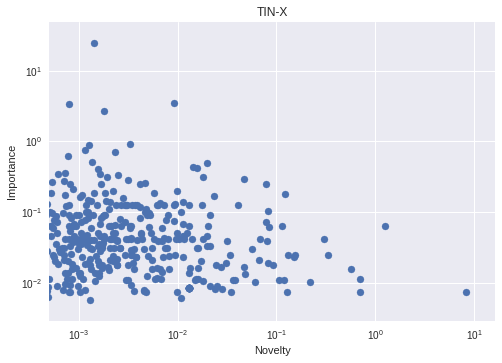

In [11]:
matplotlib.pyplot.scatter(tinx.novelty, tinx.importance)
matplotlib.pyplot.xscale('log')
matplotlib.pyplot.yscale('log')
matplotlib.pyplot.xlabel('Novelty')
matplotlib.pyplot.ylabel('Importance')
matplotlib.pyplot.title('TIN-X')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlim((max(tinx.novelty.min(),1e-3)/2,tinx.novelty.max()*2))
matplotlib.pyplot.ylim(max(tinx.importance.min()/2,1e-6), tinx.importance.max()*2)
matplotlib.pyplot.show()

### Altair interactive plot
  * https://altair-viz.github.io/

In [12]:
palette = altair.Scale(domain=['Tclin', 'Tchem', 'Tbio', 'Tdark'], range=['green', 'blue', 'red', 'gray'])
click = altair.selection_multi(fields=['tdl'])
altair.Chart(tinx, title='TIN-X: %s'%disease_name).transform_calculate(
    url='http://pharos.nih.gov/idg/targets/'+altair.datum.uniprot
    ).mark_point().encode(
      x=altair.X('novelty', scale=altair.Scale(type='log', domain=(tinx.novelty.min()*2, tinx.novelty.max()))),
      y=altair.Y('importance', scale=altair.Scale(type='log', domain=(tinx.importance.min(), tinx.importance.max()))),
      color=altair.condition(click,
                        'tdl:N', altair.value('lightgray'), 
                        scale=palette, legend=altair.Legend(title='TDL')),
    shape=altair.Shape('fam', legend=altair.Legend(title='Family')),
      href='url:N',
      tooltip=['id:N', 'name:N', 'fam:N', 'tdl:N', 'uniprot:N', 'url:N']
).properties(selection=click)

Chart({
  data:                                                     name uniprot     fam  \
  id                                                                         
  9591                         Tyrosine-protein kinase Lyn  P07948  Kinase   
  3720                                         Contactin-4  Q8IWV2    None   
  1984                                            Calnexin  P27824    None   
  2995                T-lymphocyte activation antigen CD80  P33681    None   
  7      HLA class I histocompatibility antigen, B-13 a...  P30461    None   
  2352                Antigen-presenting glycoprotein CD1d  P15813    None   
  10440                                Protein Mis18-alpha  Q9NYP9    None   
  2387                                  Carboxypeptidase B  P15086  Enzyme   
  13071  Polycystic kidney disease and receptor for egg...  Q9NTG1      IC   
  7009                                          Granzyme K  P49863  Enzyme   
  14099                                        GTPase KRas  P01116  Enzyme   
  9705                       Melanoma-associated antigen 3  P43357    None   
  18074                 Ubiquitin-conjugating enzyme E2 Q2  Q8WVN8    None   
  3681              C-type lectin domain family 7 member A  Q9BXN2    None   
  6932                               GTP-binding protein 1  O00178    None   
  295    HLA class I histocompatibility antigen, B-59 a...  Q29940    None   
  3376                 Leukocyte cell-derived chemotaxin 1  O75829    None   
  1793                                           Caspase-5  P51878  Enzyme   
  174                       APOBEC1 complementation factor  Q9NQ94    None   
  6845                                  Glucosylceramidase  P04062  Enzyme   
  10885                            Beta-microseminoprotein  P08118    None   
  10301                 Mitogen-activated protein kinase 1  P28482  Kinase   
  12642                                   Pyridoxal kinase  O00764  Kinase   
  1064      Arachidonate 5-lipoxygenase-activating protein  P20292  Enzyme   
  19     HLA class I histocompatibility antigen, B-52 a...  P30490    None   
  1892                               C-C motif chemokine 4  P13236    None   
  4222                                 Cytochrome P450 2B6  P20813    None   
  3390                                     Complement C4-A  P0C0L4    None   
  11607                        GATOR complex protein NPRL3  Q12980  Enzyme   
  14121  RNA-binding motif, single-stranded-interacting...  P29558    None   
  ...                                                  ...     ...     ...   
  1693                   Calcitonin gene-related peptide 2  P10092    None   
  3126          Hematopoietic progenitor cell antigen CD34  P28906    None   
  907                         AP-1 complex subunit sigma-2  P56377    None   
  14909           Ras-responsive element-binding protein 1  Q92766      TF   
  3963                                        Cytochrome c  P99999    None   
  294    HLA class I histocompatibility antigen, B-58 a...  P10319    None   
  3989                     Connective tissue growth factor  P29279    None   
  11600                                     Nephrocystin-4  O75161    None   
  8261                                     Integrin beta-1  P05556    None   
  10758                         Myc proto-oncogene protein  P01106      TF   
  15551  Basic helix-loop-helix transcription factor sc...  Q7RTU7      TF   
  8530          Interleukin-1 receptor-associated kinase 4  Q9NWZ3  Kinase   
  7745                   Hepatocyte nuclear factor 4-gamma  Q14541      NR   
  8988           Mast/stem cell growth factor receptor Kit  P10721  Kinase   
  3516                          Complement receptor type 1  P17927    None   
  7911               Insulin-like growth factor 1 receptor  P08069  Kinase   
  6808          Putative glutathione hydrolase 3 proenzyme  A6NGU5  Enzyme   
  15815                      Peroxisomal sarcosine oxidase  Q9P0Z9  Enzyme   
  5336  

### For a selected target, fetch articles.

In [17]:
target_id = 3818
action = ["diseases", "targets", "articles", "list"]
params = { "disease_id":disease_id, "target_id":target_id, "limit":1000, "offset":0 }
response = client.action(schema, action, params=params)
articles = pandas.DataFrame(response['results'])
print("Articles: %d"%(articles.shape[0]))
articles['PubMed_URL'] = articles.id.astype('str').str.replace('^(.*)$', 'https://www.ncbi.nlm.nih.gov/pubmed/\\1')
articles.head()

Articles: 45


,id,title,journal,date,authors,abstract,PubMed_URL
0,25873399,Inpatient management of gout in a New Zealand ...,International journal of rheumatic diseases,2016-02,"Kennedy, Nicholas J NJ, Healy, Paul J PJ and H...",To review inpatient management of acute gout i...,https://www.ncbi.nlm.nih.gov/pubmed/25873399
1,23195793,ACTH as first line treatment for acute gout in...,"Joint, bone, spine : revue du rhumatisme",2013-05,"Daoussis, Dimitrios D, Antonopoulos, Ioannis I...",We aimed at assessing the efficacy and safety ...,https://www.ncbi.nlm.nih.gov/pubmed/23195793
2,21575286,Gout.,BMJ clinical evidence,2011-05-17,"and Underwood, Martin M.","Gout affects about 5% of men and 1% of women, ...",https://www.ncbi.nlm.nih.gov/pubmed/21575286
3,21222262,Melanocortin control of cell trafficking in va...,Advances in experimental medicine and biology,2010,"Patel, Hetal B HB, Leoni, Giovanna G, Melendez...",Over 20 years of research based upon applicati...,https://www.ncbi.nlm.nih.gov/pubmed/21222262
4,19463070,Gout--what are the treatment options?,Expert opinion on pharmacotherapy,2009-06,"Schlesinger, Naomi N, Dalbeth, Nicola N and Pe...",There has been an increase in the incidence an...,https://www.ncbi.nlm.nih.gov/pubmed/19463070
